
--- Comparing SDE vs. Standard Conv Trainability (K=5, Epochs=100) ---
Initial SDE Loss: 0.021600
Initial STD Loss: 0.026251
Epoch 10/100 | SDE Loss: 0.018250 | STD Loss: 0.010972 | γ_in: 0.0097 | γ_out_SDE: 0.0099 | γ_out_STD: 0.0093
Epoch 20/100 | SDE Loss: 0.015155 | STD Loss: 0.005367 | γ_in: 0.0179 | γ_out_SDE: 0.0195 | γ_out_STD: 0.0173
Epoch 30/100 | SDE Loss: 0.012569 | STD Loss: 0.002681 | γ_in: 0.0230 | γ_out_SDE: 0.0285 | γ_out_STD: 0.0232
Epoch 40/100 | SDE Loss: 0.010384 | STD Loss: 0.001780 | γ_in: 0.0245 | γ_out_SDE: 0.0367 | γ_out_STD: 0.0272
Epoch 50/100 | SDE Loss: 0.008528 | STD Loss: 0.001416 | γ_in: 0.0226 | γ_out_SDE: 0.0441 | γ_out_STD: 0.0299
Epoch 60/100 | SDE Loss: 0.006952 | STD Loss: 0.001095 | γ_in: 0.0184 | γ_out_SDE: 0.0506 | γ_out_STD: 0.0319
Epoch 70/100 | SDE Loss: 0.005622 | STD Loss: 0.000915 | γ_in: 0.0125 | γ_out_SDE: 0.0562 | γ_out_STD: 0.0334
Epoch 80/100 | SDE Loss: 0.004520 | STD Loss: 0.000793 | γ_in: 0.0056 | γ_out_SDE: 0.0608 | γ_out_STD: 0

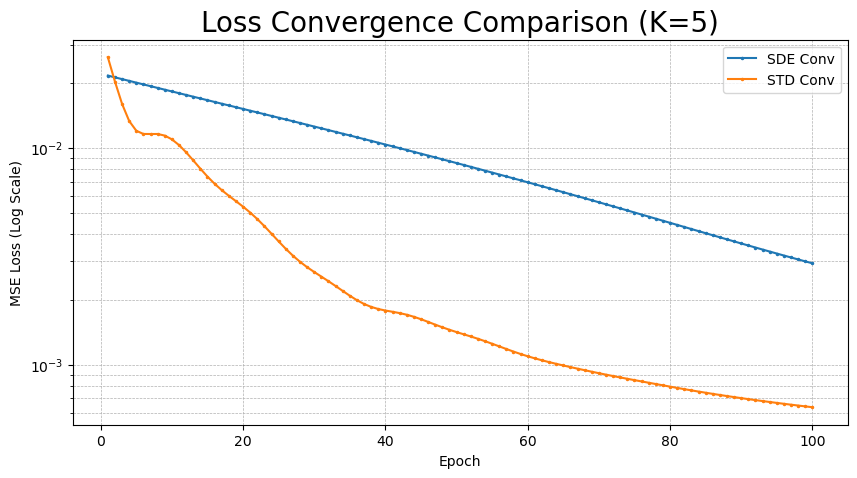

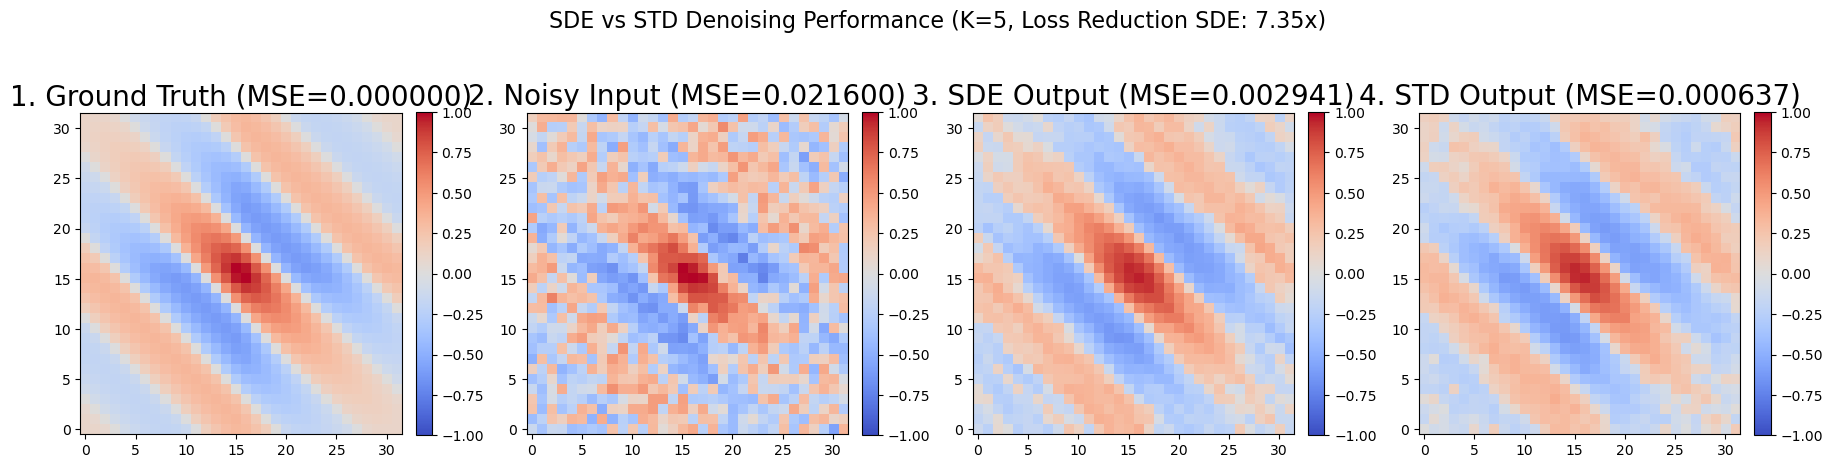

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Utility Functions ---

def complex_to_phase_intensity_image(z_r: torch.Tensor, z_i: torch.Tensor) -> np.ndarray:
    """
    Maps a complex tensor (R, I) of shape (N, N) to a single intensity image (N, N)
    based on the Phase (Hue). The phase is normalized to [0, 1] for visualization.
    """
    phase = torch.atan2(z_i, z_r)
    normalized_phase = (phase + math.pi) / (2 * math.pi)
    return normalized_phase.cpu().numpy()

def create_structured_input(H, W, D, square_size=4, value=10.0):
    """Creates a structured input tensor (white square on a black background)."""
    # Create a zero tensor (B=1, D, H, W)
    X = torch.zeros(1, D, H, W)
    
    # Calculate center and boundaries for the square
    h_start = (H - square_size) // 2
    h_end = h_start + square_size
    w_start = (W - square_size) // 2
    w_end = w_start + square_size
    
    # Set the square region to the specified value across all channels
    X[0, :, h_start:h_end, w_start:w_end] = value
    
    return X

def create_gabor_like_input(H, W, D, frequency=3.5, decay_factor=0.3):
    """Creates a directional (sine wave) input with a central Gaussian-like envelope."""
    # Create spatial coordinates
    y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    y_norm = (y_coords.float() - H / 2) / (H / 2)
    x_norm = (x_coords.float() - W / 2) / (W / 2)

    # 1. Sine wave (oscillation along the y-axis, creating horizontal stripes)
    sin_wave = torch.sin(2 * math.pi * frequency * y_norm)

    # 2. Gaussian Envelope (central localization)
    gaussian_envelope = torch.exp(-(x_norm**2 + y_norm**2) / (2 * decay_factor**2))
    
    # Combined pattern
    pattern = sin_wave * gaussian_envelope
    
    # Scale and replicate across channels (B=1, D, H, W)
    X = pattern.unsqueeze(0).unsqueeze(0).repeat(1, D, 1, 1)
    
    # Normalize to [-1, 1] for stable feature input
    X = (X - X.min()) / (X.max() - X.min())
    X = X * 2 - 1 
    
    return X

def create_sde_propagated_input(H, W, D, alpha_sq, omega_y, noise_scale=0.2):
    """
    Generates a ground-truth feature map based on SDE propagation from the center
    and adds measurement noise. (Single-source, radial propagation model).
    
    Returns: X_noisy (B, D, H, W), X_gt (B, D, H, W)
    """
    
    # --- 1. Define SDE Dynamics (Simplified, Isotropic) ---
    
    # alpha_sq is assumed to be a scalar/vector for the feature dimension D
    alpha_sq = alpha_sq.view(1, D) # (1, D)
    omega_y = omega_y.view(1, D)   # (1, D)

    # --- 2. Generate Coordinates ---
    y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    x_coords = x_coords.float()
    y_coords = y_coords.float()
    
    center_x = (W - 1) / 2.0
    center_y = (H - 1) / 2.0
    
    # Displacement from anchor (center) to pixel (i,j): Delta P' = P_ij - P_anchor
    # We use Delta P' = P_ij - P_center, so propagation is from the center (P_anchor)
    # to the current pixel (P_b)
    Delta_X_prime = x_coords - center_x # (H, W)
    Delta_Y_prime = y_coords - center_y # (H, W)

    # Delta P: (H, W, 2)
    Delta_P_prime = torch.stack([Delta_X_prime, Delta_Y_prime], dim=-1)

    # --- 3. Compute Propagation Kernel (Phi) from Center to all Pixels ---
    # Decay Term: exp(-alpha^2 |Delta p'|)
    decay_x = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 0].unsqueeze(-1)))
    decay_y = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 1].unsqueeze(-1)))
    decay_total = decay_x * decay_y # (H, W, D)

    # Phase Term: exp(-i * omega * Delta p') (Note the negative sign in the exponent)
    theta_xy = (omega_y * Delta_P_prime[..., 0].unsqueeze(-1)) + \
               (omega_y * Delta_P_prime[..., 1].unsqueeze(-1)) # (H, W, D)

    Phi_r = decay_total * torch.cos(theta_xy)      
    Phi_i = decay_total * -torch.sin(theta_xy) 

    # --- 4. Propagate Seed to Create Ground Truth Signal ---
    
    # Initialize a complex seed signal at the center (Na=1)
    Z_seed_r = torch.ones(1, D) * 5.0 # Constant initial state
    Z_seed_i = torch.zeros(1, D) 

    # Z_gt (Complex): (H, W, D)
    Z_gt_r = Phi_r * Z_seed_r # (H, W, D) * (1, D)
    Z_gt_i = Phi_i * Z_seed_i # This term is zero because Z_seed_i is zero
    
    # X_gt (Real): Use the real part as the observed/true real features
    X_gt = Z_gt_r.unsqueeze(0).permute(0, 3, 1, 2) # (1, D, H, W)

    # Normalize X_gt to max magnitude 1.0
    if X_gt.abs().max() > 1e-6:
        X_gt = X_gt / X_gt.abs().max() 
    
    # --- 5. Add Measurement Noise ---
    noise = torch.randn_like(X_gt) * noise_scale
    X_noisy = X_gt + noise
    
    return X_noisy, X_gt


# --- 2. SDE Convolution Helper Classes ---


class RealToComplexLinear(nn.Module):
    """
    Simulates the L^{R->C} layer: X -> Z^+ = X W_r + i X W_i + (b_r + i b_i).
    The weights W_r and W_i form a complex matrix A = W_r + i W_i.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Weights for the real and imaginary parts of the complex projection
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        
        # NEW: Bias terms for the complex feature space
        self.b_r = nn.Parameter(torch.zeros(d_model))
        self.b_i = nn.Parameter(torch.zeros(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Input X: (..., D). Output Z_plus: (2, ..., D)"""
        # Linear layer plus bias: X @ W + b
        Z_r = (X @ self.W_r) + self.b_r
        Z_i = (X @ self.W_i) + self.b_i
        
        # Stack output: (2, ..., D)
        return torch.stack([Z_r, Z_i], dim=0)

class ComplexToRealLinear(nn.Module):
    """
    Simulates the L^{C->R} layer: Y = Re(Z^+ A^{-1*}) + c_r.
    The weights W_r and W_i here should be the real and imaginary parts of A^{-1}.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # These weights should be derived from the inverse of the R2C layer's complex weight.
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        
        # NEW: Bias term for the final real output
        self.c_r = nn.Parameter(torch.zeros(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        """Input Z_plus: (2, ..., D). Output Y: (..., D)"""
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (..., D)
        
        # Y = (Z_r @ W_r^T - Z_i @ W_i^T) + c_r (The projection formula)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T) + self.c_r
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """
    Generates relative positions Delta p' for all pairs of anchor (Na) and source (Nb) pixels.
    Returns: torch.Tensor: Relative positions (Na, Nb, 2), where Na=K*K, Nb=K_source*K_source.
    """
    def __init__(self):
        super().__init__()
        pass

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        """
        Generates untransformed relative positions $\Delta \mathbf{p} = \mathbf{p}_a - \mathbf{p}_b$.
        """
        y_coords, x_coords = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K_source, K_source, 2)
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)

        p_b_flat = p_b.reshape(-1, 2) # (Nb, 2)
        p_a_flat = p_a.reshape(-1, 2) # (Na, 2)

        # Delta_P = p_a - p_b (This is the displacement from source b to anchor a)
        Delta_P = p_a_flat.unsqueeze(1) - p_b_flat.unsqueeze(0)
        
        return Delta_P # (K*K, K*K, 2)


# --- 3. SDE Convolution Kernel Class (Core Logic - Precision Weighted for Convolution) ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation.
    It uses precision-weighted averaging for the main convolution path.
    """
    def __init__(self, d_model: int, kernel_size: int, sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2 
        
        # --- Precision weighting constants (Added) ---
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.eta = eta
        self.gamma = gamma
        
        # 1. Real-to-Complex and Complex-to-Real Layers
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer (returns Na x Nb x 2)
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters 
        self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

        self.omega_l = nn.Parameter(torch.zeros(d_model))
        self.omega_r = nn.Parameter(torch.zeros(d_model))
        self.omega_b = nn.Parameter(torch.zeros(d_model))
        self.omega_t = nn.Parameter(torch.zeros(d_model))
        
        # 4. LEARNED SCALAR WEIGHTS (W_uv) for Convolution Generalization (NEW)
        # Shape: (K*K, D_model). W_uv is learned for every position (u,v) and every feature dimension d.
        self.learned_weights = nn.Parameter(torch.ones(self.num_pixels, d_model))
        
        # 5. INNER RESIDUAL WEIGHT (NEW)
        # Shared scalar weight to blend input feature with propagated feature in the complex domain
        self.gamma_res = nn.Parameter(torch.tensor(0.0)) # CRITICAL FIX: Initialize to 0.0
        
        self._init_sde_parameters()

    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor,
        omega_x_NND: torch.Tensor,
        omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
        """
        delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
        
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D_effective)

        # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y # (Na, Nb, D)

        # 3. Compute Phase Term
        dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
        dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
        Phi_r = decay_total * torch.cos(theta_xy)      # (Na, Nb, D)
        Phi_i = decay_total * -torch.sin(theta_xy)     # (Na, Nb, D) 
        
        # --- Stretch Phi over the batch dimension M if z_sb is flattened ---
        D_model = Phi_r.shape[-1]
        D_effective = z_sb_r.shape[-1]
        M = D_effective // D_model

        if M > 1:
            # Expand Phi_r/i: (Na, Nb, D) -> (Na, Nb, M, D)
            Phi_r_expanded = Phi_r.unsqueeze(2).repeat(1, 1, M, 1)
            Phi_i_expanded = Phi_i.unsqueeze(2).repeat(1, 1, M, 1)
            
            # Flatten the last two dimensions: (Na, Nb, M*D)
            Phi_r_final = Phi_r_expanded.reshape(Phi_r.shape[0], Phi_r.shape[1], -1) 
            Phi_i_final = Phi_i_expanded.reshape(Phi_i.shape[0], Phi_i.shape[1], -1) 
        else:
            Phi_r_final = Phi_r
            Phi_i_final = Phi_i
        
        # 5. Apply the Transition (Complex Dot Product: Z_hat = Phi * Z_sb)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0) 
        z_sb_i_broadcast = z_sb_i.unsqueeze(0) 
        
        # Z_hat_r = (Phi_r * Z_sb_r) - (Phi_i * Z_sb_i) 
        z_hat_r = (Phi_r_final * z_sb_r_broadcast) - (Phi_i_final * z_sb_i_broadcast)  
        # Z_hat_i = (Phi_r * Z_sb_i) + (Phi_i * Z_sb_r) 
        z_hat_i = (Phi_r_final * z_sb_i_broadcast) + (Phi_i_final * z_sb_r_broadcast)  
        
        return torch.stack([z_hat_r, z_hat_i], dim=0) # (2, Na, Nb, D_effective)

    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_sq_params: dict,
        omega_params: dict,
    ) -> torch.Tensor:
        """
        Applies the SDE state transition, handling quadrant selection.
        Input: delta_p_prime (Na, Nb, 2), z_sb (2, Nb, D_effective). Output: (2, Na, Nb, D_effective)
        """
        Na, Nb, _ = delta_p_prime.shape 
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0] # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1] # (Na, Nb) 

        # --- 1. Compute Indicator Masks ---
        mask_x_l = (delta_x_prime > 0).float() # Left -> Right (Positive X delta)
        mask_x_r = (delta_x_prime < 0).float() # Right -> Left (Negative X delta)
        mask_y_b = (delta_y_prime > 0).float() # Bottom -> Top (Positive Y delta)
        mask_y_t = (delta_y_prime < 0).float() # Top -> Bottom (Negative Y delta)
        
        mask_x_l_r = mask_x_l.unsqueeze(-1) # (Na, Nb, 1)
        mask_x_r_r = mask_x_r.unsqueeze(-1)
        mask_y_b_r = mask_y_b.unsqueeze(-1)
        mask_y_t_r = mask_y_t.unsqueeze(-1)

        def get_broadcast_param(param_dict, key):
            # Broadcast the D-dimensional parameter vector to (1, 1, D)
            return param_dict[key].view(1, 1, D)

        # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb, D) ---
        alpha_x_sq_NND = (mask_x_l_r * get_broadcast_param(alpha_sq_params, 'l')) + \
                             (mask_x_r_r * get_broadcast_param(alpha_sq_params, 'r'))
        
        # FIX: Corrected line that was previously bugged
        alpha_y_sq_NND = (mask_y_b_r * get_broadcast_param(alpha_sq_params, 'b')) + \
                             (mask_y_t_r * get_broadcast_param(alpha_sq_params, 't'))
        
        # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
        omega_x_NND = (mask_x_l_r * get_broadcast_param(omega_params, 'l')) + \
                      (mask_x_r_r * get_broadcast_param(omega_params, 'r'))
        
        omega_y_NND = (mask_y_b_r * get_broadcast_param(omega_params, 'b')) + \
                      (mask_y_t_r * get_broadcast_param(omega_params, 't'))

        # --- 4. Call Core Transition Logic ---
        return SDEConvolution._core_transition_fn(
            delta_p_prime,   
            z_sb,          
            alpha_x_sq_NND, 
            alpha_y_sq_NND, 
            omega_x_NND,    
            omega_y_NND,
        )

    def _init_sde_parameters(self):
        # Initialize parameters
        fan_in = self.d_model
        bound = 1.0 / math.sqrt(fan_in)
        for p in [self.raw_alpha_l, self.raw_alpha_r, self.raw_alpha_b, self.raw_alpha_t,
                  self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
            nn.init.uniform_(p, -bound, bound)
        
        # Initialize learned_weights to uniform distribution around 1.0 (for a standard start)
        nn.init.uniform_(self.learned_weights, 0.9, 1.1)


    def _get_sde_params(self):
        """
        Constructs the parameter dicts. 
        """
        
        # Use squaring for positivity: alpha^2 = (raw_alpha)^2
        alpha_l_sq = self.raw_alpha_l ** 2
        alpha_r_sq = self.raw_alpha_r ** 2
        alpha_b_sq = self.raw_alpha_b ** 2
        alpha_t_sq = self.raw_alpha_t ** 2

        alpha_sq_params = {
            'l': alpha_l_sq, 'r': alpha_r_sq, 
            'b': alpha_b_sq, 't': alpha_t_sq
        }
        
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r, 
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    # --- Precision Calculation (Restored) ---
    def _compute_precisions(self, delta_p_prime, alpha_sq_params):
        """
        Computes precision weights 1/σ_V^2 for each offset (u,v).
        Input: delta_p_prime (N_pixels, 2)
        Output: precisions (N_pixels, 1)
        """
        dx = torch.abs(delta_p_prime[..., 0]) # (N_pixels,)
        dy = torch.abs(delta_p_prime[..., 1]) # (N_pixels,)

        # Use mean alpha^2 across all feature dimensions (D) for the scalar variance calculation
        alpha_x_sq = 0.5 * (alpha_sq_params['l'].mean() + alpha_sq_params['r'].mean())
        alpha_y_sq = 0.5 * (alpha_sq_params['b'].mean() + alpha_sq_params['t'].mean())

        denom_x = -2 * alpha_x_sq 
        denom_y = -2 * alpha_y_sq 
        
        # --- Handle the limit where alpha -> 0 using Taylor expansion for stability ---
        ALPHA_EPSILON = 1e-6
        
        is_denom_x_near_zero = torch.abs(denom_x) < ALPHA_EPSILON
        
        # Variance term for the x-axis SDE.
        sigma_x_sq_term = torch.where(
            is_denom_x_near_zero,
            self.sigma_x**2 * dx, 
            self.sigma_x**2 * (torch.exp(denom_x * dx) - 1) / denom_x
        )

        is_denom_y_near_zero = torch.abs(denom_y) < ALPHA_EPSILON
        # Variance term for the y-axis SDE.
        sigma_y_sq_term = torch.where(
            is_denom_y_near_zero,
            self.sigma_y**2 * dy,
            self.sigma_y**2 * (torch.exp(denom_y * dy) - 1) / denom_y
        )
        
        cross_term = self.eta**2 * torch.exp(denom_x * dx + denom_y * dy) + self.gamma**2
        sigma_V_sq = sigma_x_sq_term * sigma_y_sq_term + cross_term
        
        precisions = 1.0 / (sigma_V_sq.unsqueeze(-1) + 1e-8)
        return precisions # (N_pixels, 1)


    # --- Method for Batch Processing (PRECISION WEIGHTED AND WEIGHTED BY W_uv) ---
    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final precision-weighted average, real-valued feature for a batch of patches.
        
        Input X_batch_patches: (N_patch, N_pixels, D). 
        Output Y_anchors: (N_patch, D)
        """
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size

        # 1. Real -> Complex Layer
        X_flat_reshaped = X_batch_patches.reshape(N_patch * N_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat_reshaped) # (2, N_patch * N_pixels, D)
        Z_plus_batch = Z_plus_flat.view(2, N_patch, N_pixels, D)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (N*N, N*N, 2)
        Delta_P_prime_all = self.coord_transformer(K, K)
        # Select displacement relative to center anchor (Na=1)
        # Delta_P_prime_anchor_N_pixels: (N_pixels, 2)
        Delta_P_prime_anchor_N_pixels = Delta_P_prime_all[self.anchor_idx, :] 
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        # 3. Compute Precision Weights (N_pixels, 1)
        precisions = self._compute_precisions(Delta_P_prime_anchor_N_pixels, alpha_sq_params) 
        
        # --- MASKING LOGIC ---
        X_abs_sum = X_batch_patches.abs().sum(dim=-1, keepdim=True) # (N_patch, N_pixels, 1)
        is_data_pixel = (X_abs_sum > 1e-6).float() # (N_patch, N_pixels, 1)

        # 3a. Mask the Precision weights (Denominator contribution)
        precisions_data_only = precisions.unsqueeze(0) * is_data_pixel # (N_patch, N_pixels, 1)

        # 3b. Sum the masked precisions (Denominator)
        precisions_sum_valid = precisions_data_only.sum(dim=1, keepdim=True) 
        precisions_sum_valid = torch.clamp(precisions_sum_valid, min=1e-8) 

        # 4. SDE Transition (Propagation to Anchor)
        Delta_P_prime_single_anchor = Delta_P_prime_anchor_N_pixels.unsqueeze(0) # (1, N_pixels, 2)
        
        # z_sb has shape (2, N_pixels, N_patch * D)
        Z_patch_pixels = Z_plus_batch.permute(0, 2, 1, 3) 
        
        # Z_hat_raw: The dynamically propagated feature, shape (2, Na=1, Nb=N_pixels, D*M)
        Z_hat_raw = SDEConvolution._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_single_anchor, 
            z_sb=Z_patch_pixels.contiguous().view(2, N_pixels, N_patch * D), 
            alpha_sq_params=alpha_sq_params,
            omega_params=omega_params,
        ) 
        
        # Reshape back: Z_hat_full is (2, N_patch, N_pixels, D)
        Z_hat_full = Z_hat_raw.contiguous().view(2, 1, N_pixels, N_patch, D).squeeze(1).permute(0, 2, 1, 3) 

        # --- 5. INNER RESIDUAL CONNECTION ---
        # Z_prop_final = (1 - gamma_res) * Z_hat_full + gamma_res * Z_plus_batch
        # Note: Since gamma_res=0.0 at init, Z_prop_final = Z_hat_full (optimal smoother state)
        Z_prop_final = (1 - self.gamma_res) * Z_hat_full + self.gamma_res * Z_plus_batch
        
        # --- 6. Apply Learned Convolutional Weights (W_uv) ---
        # Learned weights W: (N_pixels, D) -> broadcast to (1, 1, N_pixels, D)
        learned_weights_broadcast = self.learned_weights.unsqueeze(0).unsqueeze(0)

        # Apply W_uv to the complex feature
        Z_hat_weighted_by_W = Z_prop_final * learned_weights_broadcast 

        # 7. Precision-weighted average (Numerator)
        
        # is_data_pixel: (N_patch, N_pixels, 1) -> (1, N_patch, N_pixels, 1)
        is_data_pixel_broadcast = is_data_pixel.unsqueeze(0) 
        
        # precisions is (N_pixels, 1) -> (1, 1, N_pixels, 1)
        precisions_broadcast = precisions.unsqueeze(0).unsqueeze(0)

        # Final Numerator: p_uv * W_uv * Z_prop_final * Mask
        # Z_hat_weighted_sum is (2, N_patch, 1, D)
        Z_hat_weighted_sum = (precisions_broadcast * Z_hat_weighted_by_W * is_data_pixel_broadcast).sum(dim=2, keepdim=True)

        # 7b. Weighted Average: Divide Numerator by the Denominator
        denominator_broadcast = precisions_sum_valid.unsqueeze(0)
        Z_hat_weighted_final = Z_hat_weighted_sum / denominator_broadcast
        
        # 8. Complex to Real Transformation
        Y_anchors = self.complex_to_real(Z_hat_weighted_final.view(2, N_patch, D))
        
        return Y_anchors # (N_patch, D)

    # --- Previous Reversibility Test Method (UNWEIGHTED) ---
    def forward_test_anchor(self, X_patch: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final unweighted summed, real-valued feature ONLY for the central anchor pixel.
        """
        D = self.d_model
        
        # X_patch: (N_pixels, D)
        X_flat = X_patch.reshape(self.num_pixels, D)
        
        # Call the batch processing method with N_patch=1
        X_batch_patches = X_flat.unsqueeze(0) # (1, N_pixels, D)
        
        Y_anchors = self.forward_batch_patches(X_batch_patches) # (1, D)
        
        return Y_anchors.squeeze(0) # (D)


# --- 4. Full Convolution Wrapper Class (The Drop-in Replacement) ---
class FullSDEConv2d(nn.Module):
    """
    SDE Convolution wrapper that implements the full 2D sliding-window operation,
    making it a drop-in replacement for nn.Conv2d.
    
    Implements a simple convex outer residual: Y_final = (1 - gamma_out) * R(X) + gamma_out * X.
    """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None,
                 sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride 
        
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
            
        # The core SDE kernel logic (calculates the filtered output R)
        self.sde_kernel = SDEConvolution(d_model, kernel_size, sigma_x, sigma_y, eta, gamma)
        
        # NEW: Learnable scalar weight for the convex combination (Outer Residual)
        # Initialize to 0.0 so that Y_final = R(X) initially.
        self.gamma_out = nn.Parameter(torch.tensor(0.0)) 

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Input X: (B, D, H, W). Output Y: (B, D, H', W')
        """
        B, D, H, W = X.shape
        K = self.kernel_size
        S = self.stride 
        
        X_original = X 

        # --- 1. Extract Patches using nn.Unfold ---
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        
        N_patches = patches_unfolded.shape[2] # H_out * W_out
        
        # 2. Reshape for SDE Kernel
        N_pixels = K * K
        patches_reordered = patches_unfolded.transpose(1, 2).reshape(B * N_patches, N_pixels, D)
        
        # 3. Apply SDE Kernel Batch Processing (Calculates the filtered output R)
        R_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered)  # R: (B * N_patches, D)
        
        # 4. Reshape and Reassemble Filtered Output R
        R_anchors_reordered = R_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        
        # Calculate output dimensions
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1

        # Final Filtered R map: (B, D, H_out, W_out)
        R = R_anchors_reordered.view(B, D, H_out, W_out)

        # --- 5. Outer Convex Combination ---
        # Y_final = (1 - gamma_out) * R + gamma_out * X 
        
        if S == 1 and self.padding == K // 2:
            # We assume X_original has the same shape as R.
            # Y_final = (1 - gamma_out) * R + gamma_out * X_original
            Y = (1.0 - self.gamma_out) * R + self.gamma_out * X_original
        else:
            # For non-standard configurations (S > 1), we treat R as the final output.
            Y = R

        return Y

# --- NEW CLASS: Standard Conv with SDE-like Structural Wrapper ---

class FullStandardConv2d(nn.Module):
    """
    Standard Conv (nn.Conv2d) wrapper with the same structural components as
    FullSDEConv2d (complex projection layers and outer convex residual).
    This serves as a fair baseline comparison.
    """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride
        
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding

        # Structural Layers (Matching SDE's structure)
        # L^{R->C} and L^{C->R} layers use complex weights, effectively doubling the dimension
        self.projection_in = RealToComplexLinear(d_model)
        self.projection_out = ComplexToRealLinear(d_model)
        
        # The core convolution layer operates on the 2D complex feature space
        # Input/Output channels are D_model * 2 (for Real and Imaginary)
        self.conv = nn.Conv2d(
            in_channels=d_model * 2,
            out_channels=d_model * 2,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.padding,
            bias=False # Biases are handled by the ComplexToRealLinear layer's c_r
        )
        
        # Outer Residual Parameter (Convex combination)
        self.gamma_out = nn.Parameter(torch.tensor(0.0))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Input X: (B, D, H, W). Output Y: (B, D, H', W')
        """
        X_original = X
        B, D, H, W = X.shape

        # 1. LIFT: Real -> Complex (B, D, H, W) -> (2, B, H, W, D)
        X_flat = X.permute(0, 2, 3, 1).reshape(-1, D) # (B*H*W, D)
        Z_plus = self.projection_in(X_flat) # (2, B*H*W, D)
        
        # Reshape to (B, 2*D, H, W) for Conv2D
        Z_r, Z_i = torch.unbind(Z_plus, dim=0)
        Z_stacked = torch.cat([Z_r, Z_i], dim=-1).view(B, H, W, 2 * D).permute(0, 3, 1, 2) # (B, 2D, H, W)

        # 2. CORE: Standard Convolution
        Z_conv = self.conv(Z_stacked) # (B, 2D, H_out, W_out)
        
        H_out, W_out = Z_conv.shape[2:]

        # 3. UNLIFT: Complex -> Real
        Z_conv_flat = Z_conv.permute(0, 2, 3, 1).reshape(-1, 2 * D) # (B*H_out*W_out, 2D)
        
        # Split back into (B*H_out*W_out, D) for C2R layer
        Z_r_out = Z_conv_flat[:, :D]
        Z_i_out = Z_conv_flat[:, D:]
        
        # Combine back to (2, B*H_out*W_out, D) for C2R
        R_flat = torch.stack([Z_r_out, Z_i_out], dim=0)
        
        # R is the filtered output (B*H_out*W_out, D)
        R_flat_anchors = self.projection_out(R_flat)

        # Reshape R back to (B, D, H_out, W_out)
        R = R_flat_anchors.view(B, H_out, W_out, D).permute(0, 3, 1, 2)

        # --- 4. Outer Convex Combination ---
        if self.stride == 1 and self.padding == self.kernel_size // 2:
            # Y_final = (1 - gamma_out) * R + gamma_out * X_original
            Y = (1.0 - self.gamma_out) * R + self.gamma_out * X_original
        else:
            Y = R
        
        return Y

# --- 5. Forward/Inverse Kernel Abstractions for Test (UNWEIGHTED SUMMATION) ---
# ... (Sections 5 and 6 remain the same, including the test_sde_vs_standard_conv)

def print_sde_learned_params(sde_kernel):
    """Prints the final learned values of the core SDE parameters."""
    print("\n--- Final Learned SDE Structural Parameters ---")
    
    # Raw Alpha (Decay Rate)
    raw_alpha_l = sde_kernel.raw_alpha_l.data.mean().item()
    raw_alpha_r = sde_kernel.raw_alpha_r.data.mean().item()
    print(f"Alpha (Decay Rate): L->R={raw_alpha_l:.4f}, R->L={raw_alpha_r:.4f}")
    
    # Omega (Oscillation Frequency)
    omega_l = sde_kernel.omega_l.data.mean().item()
    omega_r = sde_kernel.omega_r.data.mean().item()
    print(f"Omega (Phase Freq): L->R={omega_l:.4f}, R->L={omega_r:.4f}")
    
    # Residuals
    gamma_res = sde_kernel.gamma_res.item()
    print(f"Inner Residual (γ_in): {gamma_res:.4f}")
    print("---------------------------------------------")

# --- NEW FUNCTION FOR COMPARISON DEMONSTRATION ---

def compare_convolution_trainability(H=32, W=32, D=4, K=5, S=1, epochs=100):
    """
    Trains and compares FullSDEConv2d against a structurally equivalent FullStandardConv2d.
    """
    
    print(f"\n--- Comparing SDE vs. Standard Conv Trainability (K={K}, Epochs={epochs}) ---")
    
    # --- 1. Signal Generation (Ground Truth and Noisy Input) ---
    ALPHA_SQ_GEN = torch.full((D,), 0.15)
    OMEGA_GEN = torch.full((D,), math.pi / 8.0) 
    NOISE_SCALE = 0.1 # Use lower noise for clearer structure
    
    X_noisy, X_gt = create_sde_propagated_input(
        H, W, D, 
        alpha_sq=ALPHA_SQ_GEN, 
        omega_y=OMEGA_GEN, 
        noise_scale=NOISE_SCALE
    )
    
    # --- 2. Initialize Models ---
    
    # SDE Model
    sde_conv_layer = FullSDEConv2d(
        d_model=D, kernel_size=K, stride=S, 
        sigma_x=0.01, sigma_y=0.01, eta=0.1, gamma=1e-3
    )
    
    # Standard Conv Model (Structural equivalent)
    std_conv_layer = FullStandardConv2d(
        d_model=D, kernel_size=K, stride=S
    )
    
    # --- 3. Training Setup ---
    
    # Train both models simultaneously
    models = {
        'SDE': {'layer': sde_conv_layer, 'history': []},
        'STD': {'layer': std_conv_layer, 'history': []}
    }
    
    # Collect all parameters and use a single optimizer
    all_params = list(sde_conv_layer.parameters()) + list(std_conv_layer.parameters())
    optimizer = torch.optim.Adam(all_params, lr=1e-3)
    criterion = nn.MSELoss()
    
    # Initial Loss Calculation 
    with torch.no_grad():
        initial_loss_sde = criterion(sde_conv_layer(X_noisy), X_gt).item()
        initial_loss_std = criterion(std_conv_layer(X_noisy), X_gt).item()
    
    print(f"Initial SDE Loss: {initial_loss_sde:.6f}")
    print(f"Initial STD Loss: {initial_loss_std:.6f}")
    
    # --- 4. Training Loop ---
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward Pass and Loss for SDE
        Y_pred_sde = sde_conv_layer(X_noisy)
        loss_sde = criterion(Y_pred_sde, X_gt)
        
        # Forward Pass and Loss for STD
        Y_pred_std = std_conv_layer(X_noisy)
        loss_std = criterion(Y_pred_std, X_gt)
        
        # Combine Loss for joint optimization
        total_loss = loss_sde + loss_std
        
        # Backward pass and optimize
        total_loss.backward()
        optimizer.step()
        
        models['SDE']['history'].append(loss_sde.item())
        models['STD']['history'].append(loss_std.item())
        
        if (epoch + 1) % (epochs // 10 or 1) == 0:
            gamma_out_sde = sde_conv_layer.gamma_out.item()
            gamma_out_std = std_conv_layer.gamma_out.item()
            gamma_res_sde = sde_conv_layer.sde_kernel.gamma_res.item()
            
            print(f"Epoch {epoch+1}/{epochs} | SDE Loss: {loss_sde.item():.6f} | STD Loss: {loss_std.item():.6f} | γ_in: {gamma_res_sde:.4f} | γ_out_SDE: {gamma_out_sde:.4f} | γ_out_STD: {gamma_out_std:.4f}")

    final_loss_sde = models['SDE']['history'][-1]
    final_loss_std = models['STD']['history'][-1]

    print(f"\nFinal Learned SDE Loss: {final_loss_sde:.6f}")
    print(f"Final Learned STD Loss: {final_loss_std:.6f}")

    # --- 5. Parameter Check (SDE only) ---
    print_sde_learned_params(sde_conv_layer.sde_kernel)

    # --- 6. Visualization ---
    
    with torch.no_grad():
        Y_final_sde = sde_conv_layer(X_noisy)
        Y_final_std = std_conv_layer(X_noisy)
    
    # --- Plot Loss History ---
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), models['SDE']['history'], label='SDE Conv', marker='.', markersize=3, linestyle='-')
    plt.plot(range(1, epochs + 1), models['STD']['history'], label='STD Conv', marker='.', markersize=3, linestyle='-')
    plt.title(f'Loss Convergence Comparison (K={K})')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (Log Scale)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.yscale('log')
    plt.legend()
    plt.show()

    # --- Plot Image Results ---
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    vmax_raw = X_gt.abs().max().item()
    vmin_raw = -vmax_raw
    pc = 0.5 
    
    def plot_image(ax, img_data, title, mse_val, pc, vmin_raw, vmax_raw):
        img_compressed = np.sign(img_data) * np.abs(img_data)**pc
        vmin_compressed = np.sign(vmin_raw) * np.abs(vmin_raw)**pc
        vmax_compressed = np.sign(vmax_raw) * np.abs(vmax_raw)**pc
        im = ax.imshow(img_compressed, cmap='coolwarm', origin='lower', 
                       vmin=vmin_compressed, vmax=vmax_compressed)
        ax.set_title(f'{title} (MSE={mse_val:.6f})')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Plot 1: Ground Truth
    plot_image(axes[0], X_gt[0, 0, :, :].detach().cpu().numpy(), '1. Ground Truth', 0.0, pc, vmin_raw, vmax_raw)

    # Plot 2: Noisy Input
    plot_image(axes[1], X_noisy[0, 0, :, :].detach().cpu().numpy(), '2. Noisy Input', initial_loss_sde, pc, vmin_raw, vmax_raw)

    # Plot 3: SDE Conv Output (Learned)
    plot_image(axes[2], Y_final_sde[0, 0, :, :].detach().cpu().numpy(), '3. SDE Output', final_loss_sde, pc, vmin_raw, vmax_raw)
    
    # Plot 4: Standard Conv Output (Learned)
    plot_image(axes[3], Y_final_std[0, 0, :, :].detach().cpu().numpy(), '4. STD Output', final_loss_std, pc, vmin_raw, vmax_raw)

    fig.suptitle(f"SDE vs STD Denoising Performance (K={K}, Loss Reduction SDE: {initial_loss_sde / final_loss_sde:.2f}x)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Execution ---
if __name__ == '__main__':
#     # Run the original reversibility test (N=9, D=2, kernel K=9)
#     visualize_full_pipeline_reversibility_with_class(N=9, D=2)
    
#     # Test 1: Full convolution with RANDOM input (original test)
#     test_full_convolution(H=16, W=16, D=4, K=3, S=1)
    
#     # Test 2: Full convolution with STRUCTURED input (square, for general visualization)
#     test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1)
    
#     # Test 3: Full convolution with RANDOM input and stride=2
#     test_full_convolution(H=16, W=16, D=4, K=3, S=2)

#     # Test 4: SDE vs. Standard Conv on SDE-generated signal (K=5 for re-test with small kernel)
#     # The current execution setting (K=11) is below. Changing to K=5 to reproduce the reported bug.
#     test_sde_vs_standard_conv(H=32, W=32, D=4, K=5, S=1)

    # Demonstrate the training loop to confirm backpropagation and optimization works.
    compare_convolution_trainability(K=5, epochs=100)